In [1]:
#!/usr/bin/env python
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import os, sys
import numpy as np
import json
import time
from datetime import timedelta
from collections import defaultdict
import argparse
import multiprocessing

import PIL.Image as Image

from panopticapi.utils import get_traceback, rgb2id

OFFSET = 256 * 256 * 256
VOID = 0

class PQStatCat():
        def __init__(self):
            self.iou = 0.0
            self.tp = 0
            self.fp = 0
            self.fn = 0

        def __iadd__(self, pq_stat_cat):
            self.iou += pq_stat_cat.iou
            self.tp += pq_stat_cat.tp
            self.fp += pq_stat_cat.fp
            self.fn += pq_stat_cat.fn
            return self


class PQStat():
    def __init__(self):
        self.pq_per_cat = defaultdict(PQStatCat)

    def __getitem__(self, i):
        return self.pq_per_cat[i]

    def __iadd__(self, pq_stat):
        for label, pq_stat_cat in pq_stat.pq_per_cat.items():
            self.pq_per_cat[label] += pq_stat_cat
        return self

    def pq_average(self, categories, isthing):
        pq, sq, rq, n = 0, 0, 0, 0
        per_class_results = {}
        for label, label_info in categories.items():
            if isthing is not None:
                cat_isthing = label_info['isthing'] == 1
                if isthing != cat_isthing:
                    continue
            iou = self.pq_per_cat[label].iou
            tp = self.pq_per_cat[label].tp
            fp = self.pq_per_cat[label].fp
            fn = self.pq_per_cat[label].fn
            if tp + fp + fn == 0:
                per_class_results[label] = {'pq': 0.0, 'sq': 0.0, 'rq': 0.0}
                continue
            n += 1
            pq_class = iou / (tp + 0.5 * fp + 0.5 * fn)
            sq_class = iou / tp if tp != 0 else 0
            rq_class = tp / (tp + 0.5 * fp + 0.5 * fn)
            per_class_results[label] = {'pq': pq_class, 'sq': sq_class, 'rq': rq_class}
            pq += pq_class
            sq += sq_class
            rq += rq_class

        return {'pq': pq / n, 'sq': sq / n, 'rq': rq / n, 'n': n}, per_class_results


@get_traceback
def pq_compute_single_core(proc_id, annotation_set, gt_folder, pred_folder, categories):
    pq_stat = PQStat()

    idx = 0
    for gt_ann, pred_ann in annotation_set:
        if idx % 100 == 0:
            print('Core: {}, {} from {} images processed'.format(proc_id, idx, len(annotation_set)))
        idx += 1

        pan_gt = np.array(Image.open(os.path.join(gt_folder, gt_ann['file_name'])), dtype=np.uint32)
        pan_gt = rgb2id(pan_gt)
        pan_pred = np.array(Image.open(os.path.join(pred_folder, pred_ann['file_name'])), dtype=np.uint32)
        pan_pred = rgb2id(pan_pred)

        gt_segms = {el['id']: el for el in gt_ann['segments_info']}
        pred_segms = {el['id']: el for el in pred_ann['segments_info']}

        # predicted segments area calculation + prediction sanity checks
        pred_labels_set = set(el['id'] for el in pred_ann['segments_info'])
        labels, labels_cnt = np.unique(pan_pred, return_counts=True)
        for label, label_cnt in zip(labels, labels_cnt):
            if label not in pred_segms:
                if label == VOID:
                    continue
                raise KeyError('In the image with ID {} segment with ID {} is presented in PNG and not presented in JSON.'.format(gt_ann['image_id'], label))
            pred_segms[label]['area'] = label_cnt
            pred_labels_set.remove(label)
            if pred_segms[label]['category_id'] not in categories:
                raise KeyError('In the image with ID {} segment with ID {} has unknown category_id {}.'.format(gt_ann['image_id'], label, pred_segms[label]['category_id']))
        if len(pred_labels_set) != 0:
            raise KeyError('In the image with ID {} the following segment IDs {} are presented in JSON and not presented in PNG.'.format(gt_ann['image_id'], list(pred_labels_set)))

        # confusion matrix calculation
        pan_gt_pred = pan_gt.astype(np.uint64) * OFFSET + pan_pred.astype(np.uint64)
        gt_pred_map = {}
        labels, labels_cnt = np.unique(pan_gt_pred, return_counts=True)
        for label, intersection in zip(labels, labels_cnt):
            gt_id = label // OFFSET
            pred_id = label % OFFSET
            gt_pred_map[(gt_id, pred_id)] = intersection

        # count all matched pairs
        gt_matched = set()
        pred_matched = set()
        for label_tuple, intersection in gt_pred_map.items():
            gt_label, pred_label = label_tuple
            if gt_label not in gt_segms:
                continue
            if pred_label not in pred_segms:
                continue
            if gt_segms[gt_label]['iscrowd'] == 1:
                continue
            if gt_segms[gt_label]['category_id'] != pred_segms[pred_label]['category_id']:
                continue

            union = pred_segms[pred_label]['area'] + gt_segms[gt_label]['area'] - intersection - gt_pred_map.get((VOID, pred_label), 0)
            iou = intersection / union
            if iou > 0.5:
                pq_stat[gt_segms[gt_label]['category_id']].tp += 1
                pq_stat[gt_segms[gt_label]['category_id']].iou += iou
                gt_matched.add(gt_label)
                pred_matched.add(pred_label)

        # count false positives
        crowd_labels_dict = {}
        for gt_label, gt_info in gt_segms.items():
            if gt_label in gt_matched:
                continue
            # crowd segments are ignored
            if gt_info['iscrowd'] == 1:
                crowd_labels_dict[gt_info['category_id']] = gt_label
                continue
            pq_stat[gt_info['category_id']].fn += 1

        # count false positives
        for pred_label, pred_info in pred_segms.items():
            if pred_label in pred_matched:
                continue
            # intersection of the segment with VOID
            intersection = gt_pred_map.get((VOID, pred_label), 0)
            # plus intersection with corresponding CROWD region if it exists
            if pred_info['category_id'] in crowd_labels_dict:
                intersection += gt_pred_map.get((crowd_labels_dict[pred_info['category_id']], pred_label), 0)
            # predicted segment is ignored if more than half of the segment correspond to VOID and CROWD regions
            if intersection / pred_info['area'] > 0.5:
                continue
            pq_stat[pred_info['category_id']].fp += 1
    print('Core: {}, all {} images processed'.format(proc_id, len(annotation_set)))
    return pq_stat


def pq_compute_multi_core(matched_annotations_list, gt_folder, pred_folder, categories):
    cpu_num = multiprocessing.cpu_count()
    annotations_split = np.array_split(matched_annotations_list, cpu_num)
    print("Number of cores: {}, images per core: {}".format(cpu_num, len(annotations_split[0])))
    workers = multiprocessing.Pool(processes=cpu_num)
    processes = []
    for proc_id, annotation_set in enumerate(annotations_split):
        p = workers.apply_async(pq_compute_single_core,
                                (proc_id, annotation_set, gt_folder, pred_folder, categories))
        processes.append(p)
    pq_stat = PQStat()
    for p in processes:
        pq_stat += p.get()
    return pq_stat


def pq_compute(gt_json_file, pred_json_file, gt_folder=None, pred_folder=None):

    start_time = time.time()
    with open(gt_json_file, 'r') as f:
        gt_json = json.load(f)
    with open(pred_json_file, 'r') as f:
        pred_json = json.load(f)

    if gt_folder is None:
        gt_folder = gt_json_file.replace('.json', '')
    if pred_folder is None:
        pred_folder = pred_json_file.replace('.json', '')
    categories = {el['id']: el for el in gt_json['categories']}

    print("Evaluation panoptic segmentation metrics:")
    print("Ground truth:")
    print("\tSegmentation folder: {}".format(gt_folder))
    print("\tJSON file: {}".format(gt_json_file))
    print("Prediction:")
    print("\tSegmentation folder: {}".format(pred_folder))
    print("\tJSON file: {}".format(pred_json_file))

    if not os.path.isdir(gt_folder):
        raise Exception("Folder {} with ground truth segmentations doesn't exist".format(gt_folder))
    if not os.path.isdir(pred_folder):
        raise Exception("Folder {} with predicted segmentations doesn't exist".format(pred_folder))

    pred_annotations = {el['image_id']: el for el in pred_json['annotations']}
    matched_annotations_list = []
    for gt_ann in gt_json['annotations']:
        image_id = gt_ann['image_id']
        if image_id not in pred_annotations:
            raise Exception('no prediction for the image with id: {}'.format(image_id))
        matched_annotations_list.append((gt_ann, pred_annotations[image_id]))

    pq_stat = pq_compute_multi_core(matched_annotations_list, gt_folder, pred_folder, categories)

    metrics = [("All", None), ("Things", True), ("Stuff", False)]
    results = {}
    for name, isthing in metrics:
        results[name], per_class_results = pq_stat.pq_average(categories, isthing=isthing)
        if name == 'All':
            results['per_class'] = per_class_results
    print("{:10s}| {:>5s}  {:>5s}  {:>5s} {:>5s}".format("", "PQ", "SQ", "RQ", "N"))
    print("-" * (10 + 7 * 4))

    for name, _isthing in metrics:
        print("{:10s}| {:5.1f}  {:5.1f}  {:5.1f} {:5d}".format(
            name,
            100 * results[name]['pq'],
            100 * results[name]['sq'],
            100 * results[name]['rq'],
            results[name]['n'])
        )

    t_delta = time.time() - start_time
    print("Time elapsed: {:0.2f} seconds".format(t_delta))

    return results


if __name__ == "__main__":

    gt_file = '/home/mac239/hujie-project/YOSO/datasets/mapillary_vistas/validation/panoptic/panoptic_2018.json'
    pred_file = '/home/mac239/hujie-project/YOSO/output/yoso_resnet50_panoptic_seg_mapillary/inference/predictions.json'
    gt_folder = '/home/mac239/hujie-project/YOSO/datasets/mapillary_vistas/validation/panoptic'
    pred_folder = '/home/mac239/hujie-project/YOSO/output/yoso_resnet50_panoptic_seg_mapillary/inference'
    # from panopticapi.evaluation import pq_compute
    pq_res=pq_compute(gt_file, pred_file, gt_folder, pred_folder)
    res = {}
    res["PQ"] = 100 * pq_res["All"]["pq"]
    res["SQ"] = 100 * pq_res["All"]["sq"]
    res["RQ"] = 100 * pq_res["All"]["rq"]
    res["PQ_th"] = 100 * pq_res["Things"]["pq"]
    res["SQ_th"] = 100 * pq_res["Things"]["sq"]
    res["RQ_th"] = 100 * pq_res["Things"]["rq"]
    res["PQ_st"] = 100 * pq_res["Stuff"]["pq"]
    res["SQ_st"] = 100 * pq_res["Stuff"]["sq"]
    res["RQ_st"] = 100 * pq_res["Stuff"]["rq"]
    print(res)

Evaluation panoptic segmentation metrics:
Ground truth:
	Segmentation folder: /home/mac239/hujie-project/YOSO/datasets/mapillary_vistas/validation/panoptic
	JSON file: /home/mac239/hujie-project/YOSO/datasets/mapillary_vistas/validation/panoptic/panoptic_2018.json
Prediction:
	Segmentation folder: /home/mac239/hujie-project/YOSO/datasets/mapillary_vistas/validation/panoptic
	JSON file: /home/mac239/hujie-project/YOSO/datasets/mapillary_vistas/validation/panoptic/panoptic_2018.json
Number of cores: 48, images per core: 42
Core: 0, 0 from 42 images processedCore: 1, 0 from 42 images processed

Core: 2, 0 from 42 images processed
Core: 3, 0 from 42 images processed
Core: 4, 0 from 42 images processed
Core: 5, 0 from 42 images processed
Core: 6, 0 from 42 images processed
Core: 8, 0 from 42 images processedCore: 7, 0 from 42 images processedCore: 9, 0 from 42 images processed


Core: 10, 0 from 42 images processed
Core: 11, 0 from 42 images processedCore: 12, 0 from 42 images processed

Co

In [ ]:
import numpy as np
import PIL.Image as Image
from panopticapi.utils import get_traceback, rgb2id

temp1 = np.array(Image.open('/home/mac239/hujie-project/YOSO/datasets/mapillary_vistas/validation/panoptic/_1Gn_xkw7sa_i9GU4mkxxQ.png'), dtype=np.uint32)
# print(temp1.dtype)
# print(temp1)
import cv2
temp2 = np.array(cv2.imread('/home/mac239/hujie-project/YOSO/datasets/mapillary_vistas/validation/panoptic/_1Gn_xkw7sa_i9GU4mkxxQ.png'))#, dtype=np.uint32)
# print(temp2.dtype)
# print(temp2)
# print(temp1==temp2)
# print(temp1.shape, temp2.shape)
from matplotlib import pyplot as plt
plt.imshow(temp2)
plt.show()

print('----')
a = rgb2id(temp1)
print(a)

print('----')
temp1 = np.array(Image.open('/home/mac239/hujie-project/YOSO/output/yoso_resnet50_panoptic_seg_mapillary/inference/_1Gn_xkw7sa_i9GU4mkxxQ.png'), dtype=np.uint32)
# print(temp1.dtype)
# print(temp1)
import cv2
temp2 = cv2.imread('/home/mac239/hujie-project/YOSO/output/yoso_resnet50_panoptic_seg_mapillary/inference/_1Gn_xkw7sa_i9GU4mkxxQ.png')#, dtype=np.uint32)
# print(temp2.dtype)
# print(temp2)
# print(temp1==temp2)
# print(temp1.shape, temp2.shape)
from matplotlib import pyplot as plt
plt.imshow(temp2)
plt.show()

print('----')
a = rgb2id(temp1)
print(a)

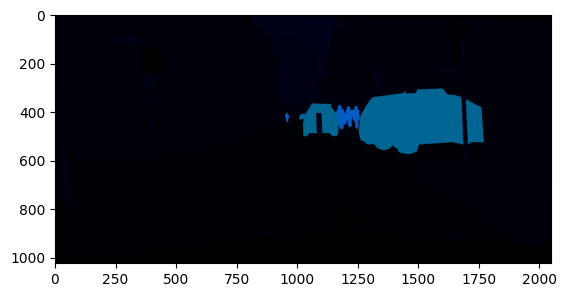

----


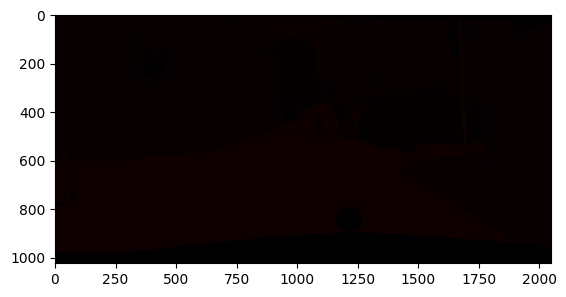

In [5]:
import numpy as np
import PIL.Image as Image
from panopticapi.utils import get_traceback, rgb2id

temp1 = np.array(Image.open('/home/mac239/hujie-project/YOSO/datasets/cityscapes/gtFine/cityscapes_panoptic_val/frankfurt_000000_000294_gtFine_panoptic.png'), dtype=np.uint32)
# print(temp1.dtype)
# print(temp1)
import cv2
temp2 = np.array(cv2.imread('/home/mac239/hujie-project/YOSO/datasets/cityscapes/gtFine/cityscapes_panoptic_val/frankfurt_000000_000294_gtFine_panoptic.png'))#, dtype=np.uint32)
# print(temp2.dtype)
# print(temp2)
# print(temp1==temp2)
# print(temp1.shape, temp2.shape)
from matplotlib import pyplot as plt
plt.imshow(temp2)
plt.show()

print('----')
temp1 = np.array(Image.open('/home/mac239/hujie-project/YOSO/output/yoso_resnet50_panoptic_seg_cityscapes/inference/frankfurt_000000_000294_leftImg8bit.png'), dtype=np.uint32)
# print(temp1.dtype)
# print(temp1)
import cv2
temp2 = cv2.imread('/home/mac239/hujie-project/YOSO/output/yoso_resnet50_panoptic_seg_cityscapes/inference/frankfurt_000000_000294_leftImg8bit.png')#, dtype=np.uint32)
# print(temp2.dtype)
# print(temp2)
# print(temp1==temp2)
# print(temp1.shape, temp2.shape)
plt.imshow(temp1)